In [1]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def correct_coordinates(latitude):
    return 0.5*(180/np.pi)*np.log(np.tan(((2*(np.pi/180)*latitude)+np.pi)/4))

class MeteoDataBase:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()
    
    def get_node_by_id(self, node_id):
        with self.driver.session() as session:
            result = session.write_transaction(self._get_node_by_id, node_id)
            return result
    
    def get_station_by_number(self, station):
        with self.driver.session() as session:
            result = session.write_transaction(self._get_station_by_number, station)
            return result
        
    def get_all_station(self):
        with self.driver.session() as session:
            result = session.write_transaction(self._get_all_station)
            return result
    
    @staticmethod
    def _get_node_by_id(tx, node_id):
        result = tx.run("MATCH (n) "
                        "WHERE id(n) = $node_id "
                        "RETURN (n)", node_id=node_id)
        return result.single()#[0] 
    
    @staticmethod
    def _get_station_by_number(tx, station):
        result = tx.run("MATCH (s:Station {numer_sta : $station}) "
                        "RETURN s", station=station)
        return result.single()#[0]
    
    @staticmethod
    def _get_all_station(tx):
        result = tx.run("MATCH (s:Station) "
                        "RETURN (s)")
        return [record for record in result]

In [2]:
meteoDataBase = MeteoDataBase("bolt://localhost:7687", "neo4j", "admin") 
    
res = meteoDataBase.get_station_by_number("07005")
print(res)
print(res[0])
print(type(res[0]))
print(res[0].get('ville'))
print(type(res[0].get('latitude')))

meteoDataBase.close()

<Record s=<Node id=4 labels=frozenset({'Station'}) properties={'numer_sta': '07005', 'altitude': 69, 'ville': 'ABBEVILLE', 'latitude': 50.136, 'longitude': 1.834}>>
<Node id=4 labels=frozenset({'Station'}) properties={'numer_sta': '07005', 'altitude': 69, 'ville': 'ABBEVILLE', 'latitude': 50.136, 'longitude': 1.834}>
<class 'neo4j.graph.Node'>
ABBEVILLE
<class 'float'>


In [3]:
meteoDataBase = MeteoDataBase("bolt://localhost:7687", "neo4j", "admin") 

df_stations = pd.DataFrame(columns=['Ville','Longitude','Latitude'])

res = meteoDataBase.get_all_station()

for line in res:
    station = line[0]
    data = {'Ville': station.get('ville'),
            'Longitude': station.get('longitude'),
            'Latitude': station.get('latitude')
           }
    #print(station.get('ville'), station.get('longitude'), station.get('latitude'))
    df_stations = df_stations.append(data, ignore_index=True)

print(df_stations.head())
print(df_stations.dtypes)

print(df_stations.Latitude.min())
print(df_stations.Latitude.max())
print(df_stations.Longitude.min())
print(df_stations.Longitude.max())
    
meteoDataBase.close()

             Ville  Longitude   Latitude
0        ABBEVILLE   1.834000  50.136000
1    LILLE-LESQUIN   3.097500  50.570000
2  PTE DE LA HAGUE  -1.939833  49.725167
3   CAEN-CARPIQUET  -0.456167  49.180000
4       ROUEN-BOOS   1.181667  49.383000
Ville         object
Longitude    float64
Latitude     float64
dtype: object
-66.663167
50.57
-62.852167
140.001


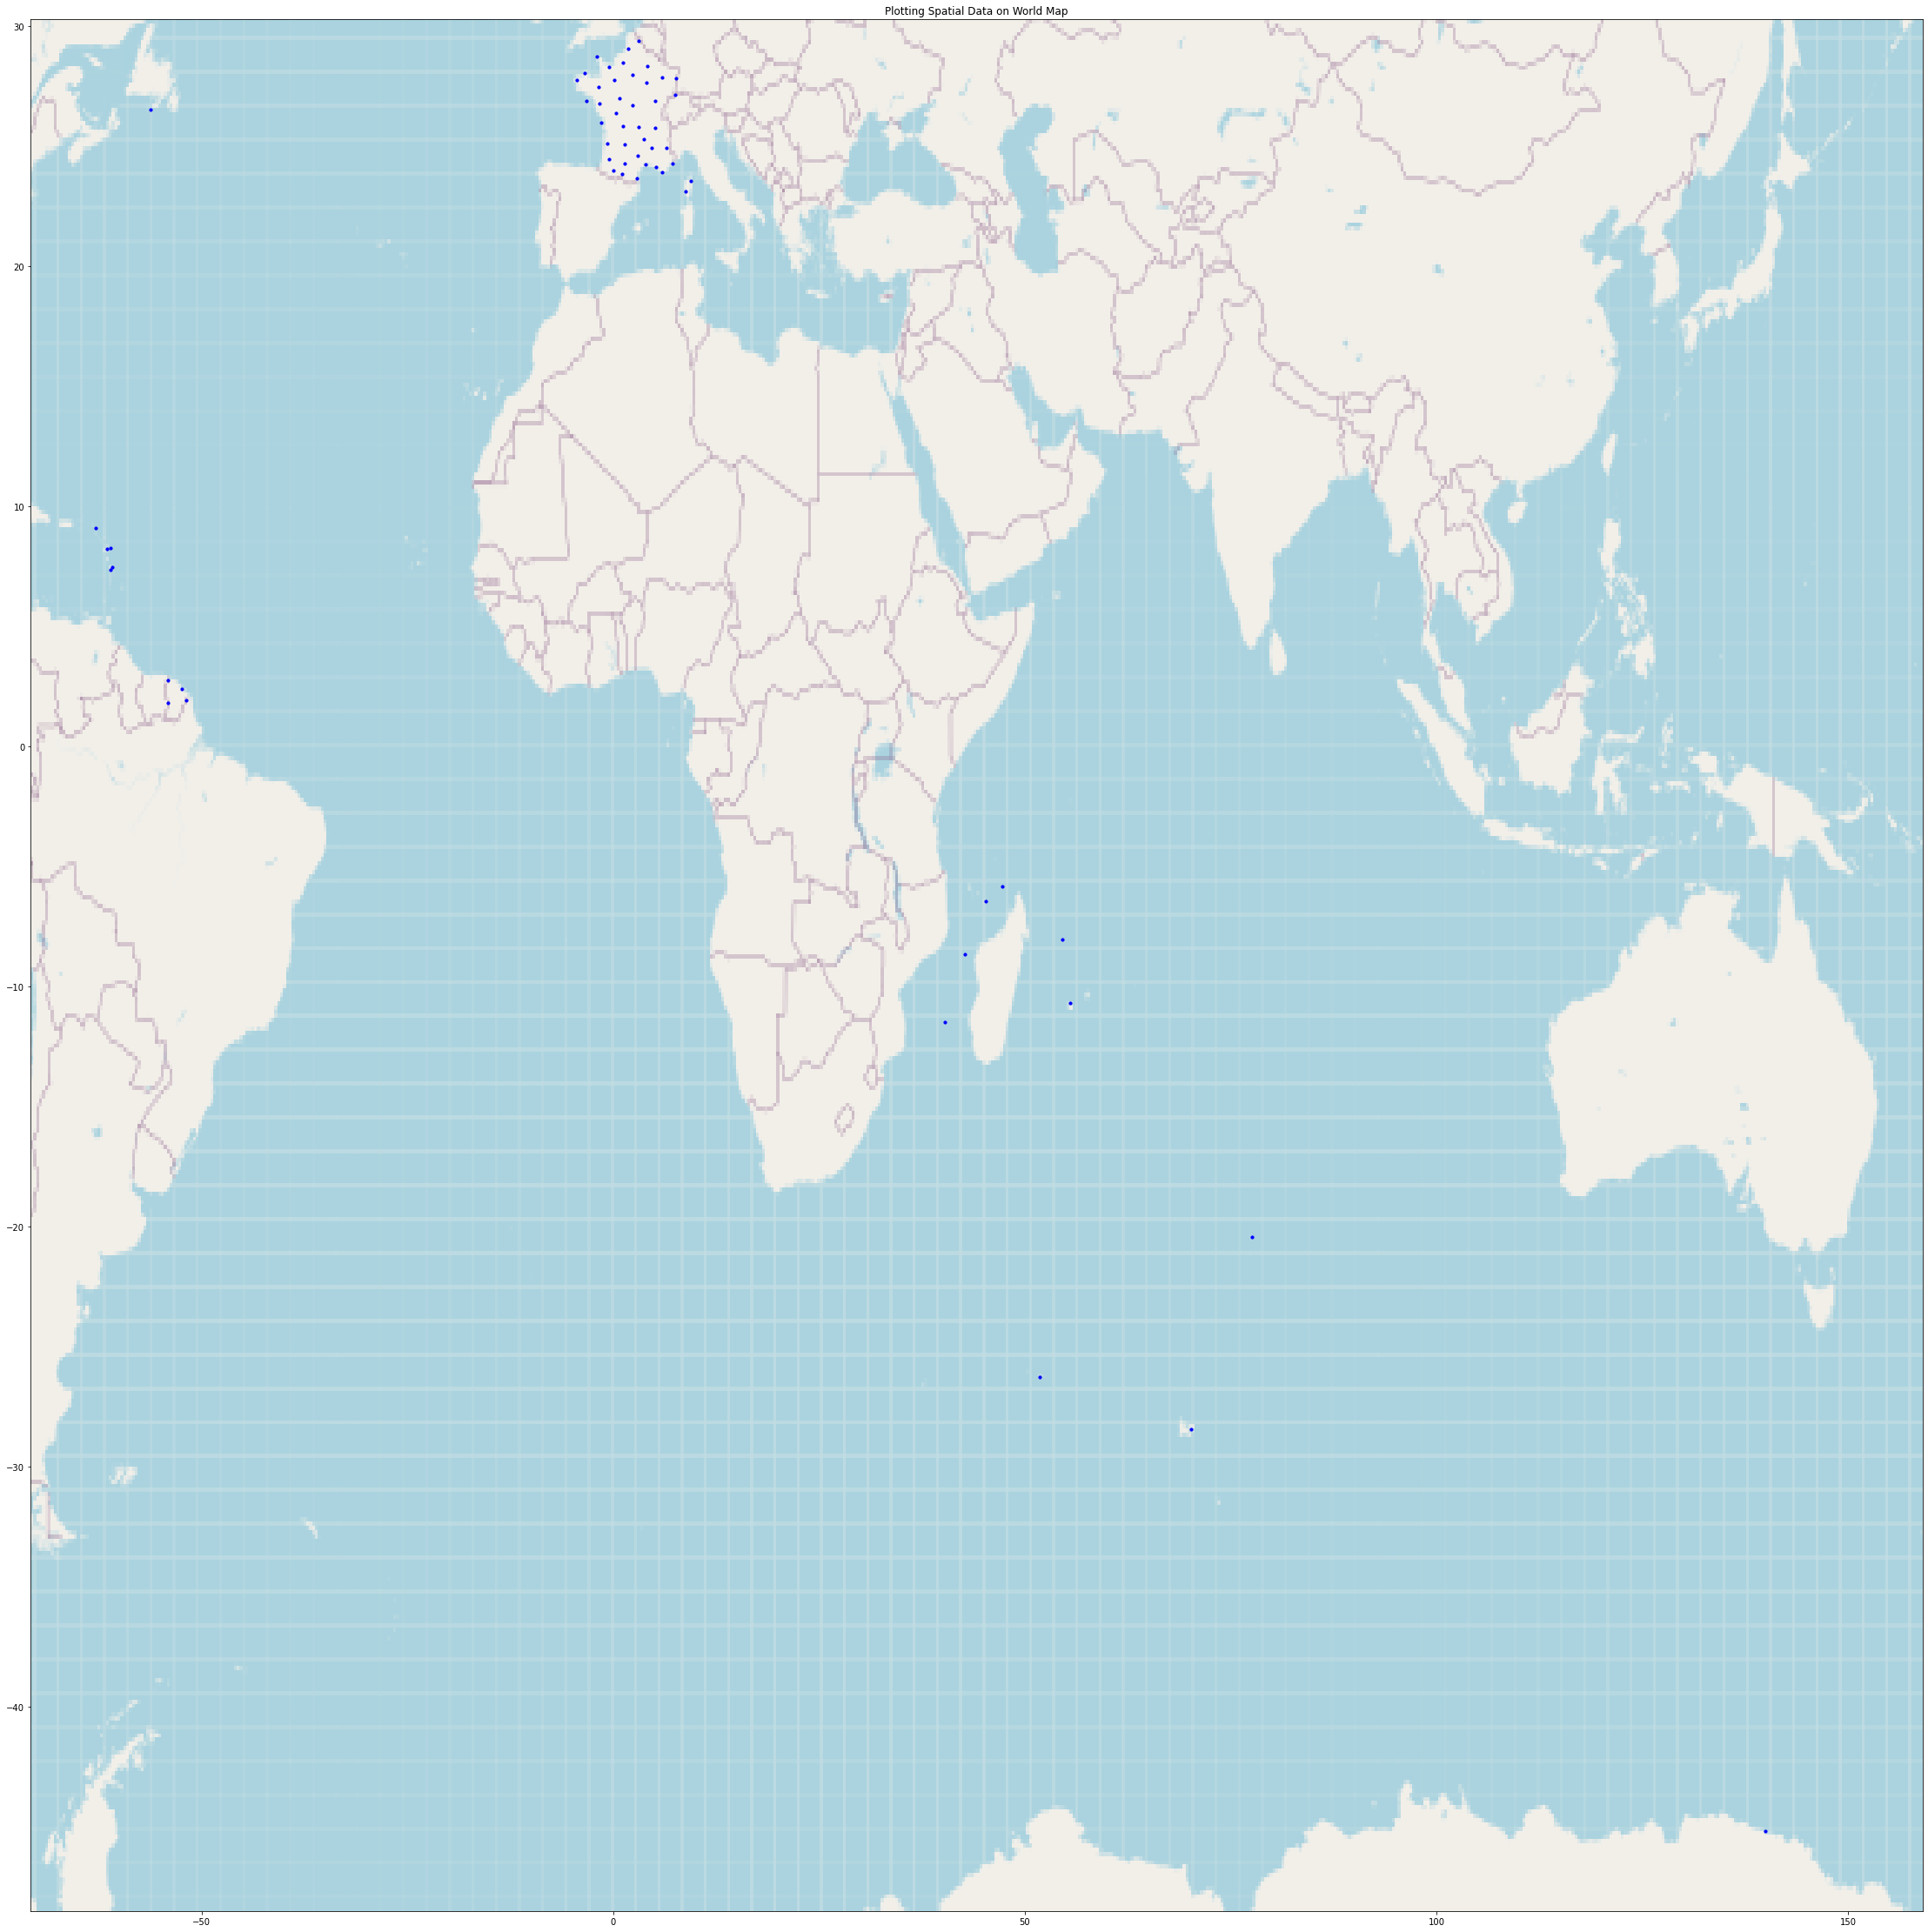

In [4]:
map_latitude_max = 51.68485
map_latitude_min = -69.15483

map_longitude_max = 159.04684
map_longitude_min = -70.73437

map_latitude_max_corrected = correct_coordinates(map_latitude_max)
map_latitude_min_corrected = correct_coordinates(map_latitude_min)

ratio = (map_longitude_max-map_longitude_min)/(map_latitude_max_corrected-map_latitude_min_corrected)

BBox = (map_longitude_min, 
        map_longitude_max,      
        map_latitude_min_corrected, 
        map_latitude_max_corrected)

world = plt.imread('data/maps/world_map.png')


fig, ax = plt.subplots(figsize = (40,40))

ax.scatter(df_stations.Longitude, 
           correct_coordinates(df_stations.Latitude),
           alpha=1, c='b', s=10)

ax.set_title('Plotting Spatial Data on World Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.imshow(world, extent=BBox, aspect=ratio)
#1.45758928571
#0.68606431853

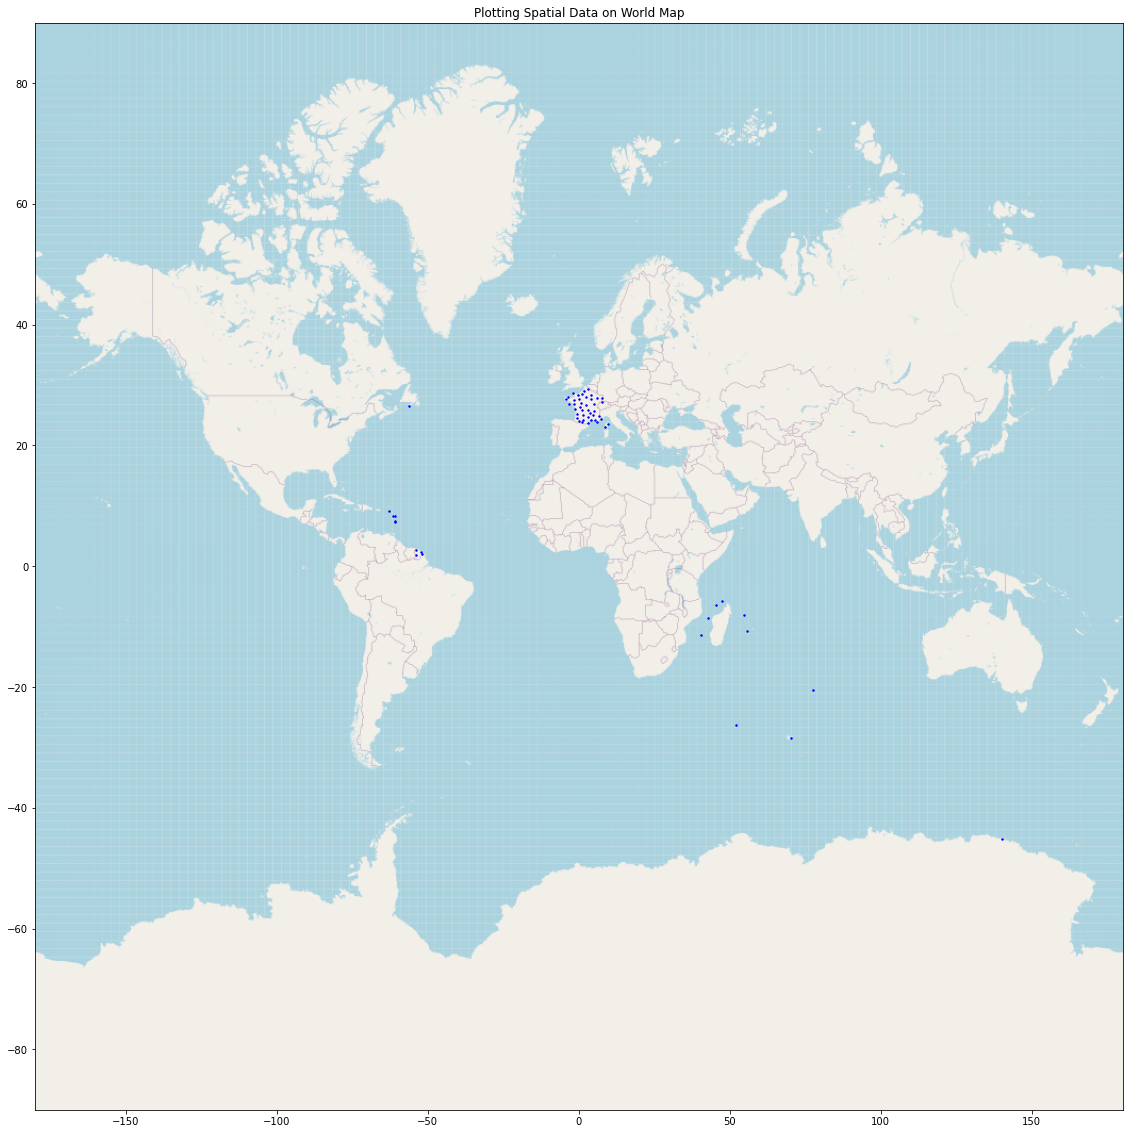

In [5]:
BBox = (-180, 180,
       -90, 90)

world = plt.imread('data/maps/world_map_backup.png')

fig, ax = plt.subplots(figsize = (20,20))
ax.scatter(df_stations.Longitude, 
           0.5*(180/np.pi)*np.log(np.tan(((2*(np.pi/180)*df_stations.Latitude)+np.pi)/4)),
           alpha=1, c='b', s=2)
ax.set_title('Plotting Spatial Data on World Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(world, extent=BBox, aspect=2)